# Grade: /100 pts

# Assignment 06: Regularization

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 500)

%matplotlib inline

### Question 1: Preprocessing (5 pts)
**Make sure to only use the imports included in the first cell. Any additional imports used will result in 0.** <br>
Tasks:
* Load the data present in 'footballer_small.csv' using the pandas library and store the loaded data in a dataframe
* Drop the variables: 'ID','club','club_logo','flag', 'nationality','photo','potential', 'birth_date'
* Dummy code the variables: work_rate_att, work_rate_def, preferred_foot. **Because we are running a regularized model, we do not want to drop the first column**
* Get a test data set of size 500 - to make results comparable to solutions, set random_state = 0 <br>

In [28]:
df = pd.read_csv("footballer_small.csv")
df = df.drop(labels=['ID', 'club', 'club_logo', 'flag','nationality','photo','potential', 'birth_date'], axis=1)

columns = ['preferred_foot', 'work_rate_att', 'work_rate_def']
df[columns] = df[columns].astype('category')

df = pd.get_dummies(df, columns=columns, drop_first=False, dtype=int)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(df.drop('overall', axis=1), df['overall'], test_size = 500, random_state = 0)
print(f"Training set size: {Xtrain.shape[0]}", f"Test set size: {Xtest.shape[0]}")

Training set size: 2500 Test set size: 500


## Question 2: Building the pipeline that preprocesses the data (10 pts)
In order to properly build the regression model, the features need to be standardized so that no feature can dominate others in determining the prediction values due to differences in feature scales. Build the pipeline that preprocesses the feature columns of the training data and create a linear regression model. Plot the data before and after the standardization for the stamina feature. <br>
In this question, there is no need to overwrite the training set's values. Create a new variable to include the standardized data. The original training data is needed for future exercises. <br>
### Question
Make observations about the plot.  

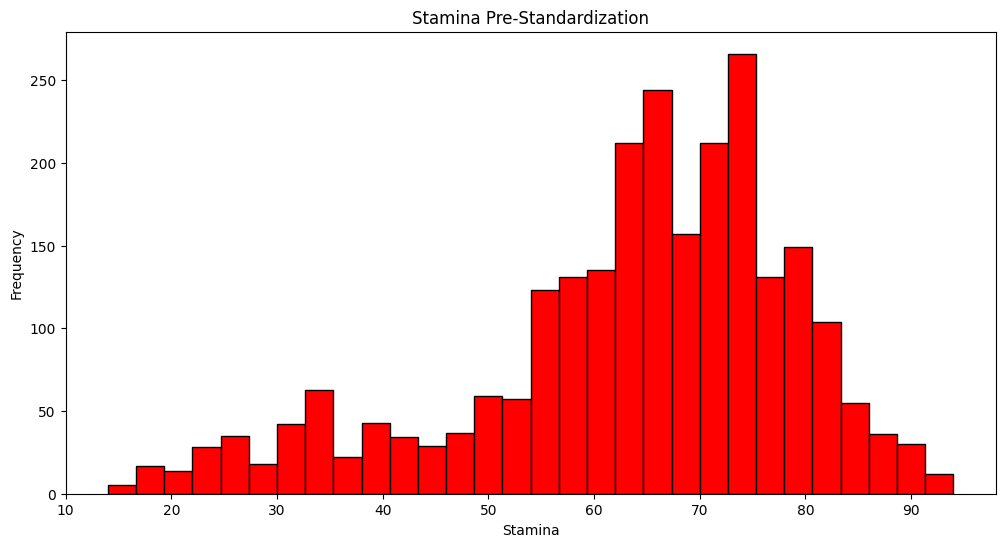

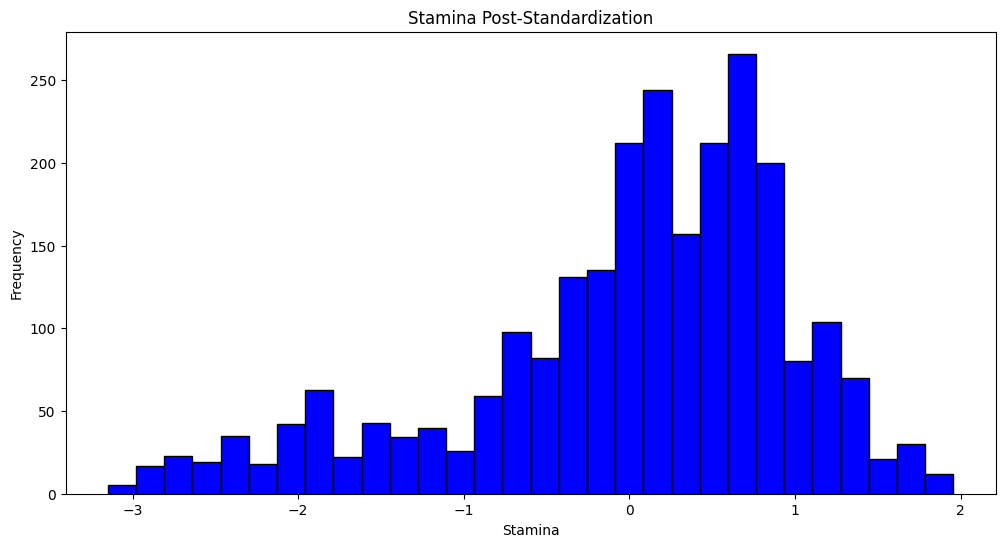

In [29]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge()) 
])

scaler = StandardScaler()
XtrainSTRD = Xtrain.copy().astype(float)
XtrainSTRD.iloc[:, :] = scaler.fit_transform(Xtrain.copy().astype(float))

plt.figure(figsize=(12,6))
plt.hist(Xtrain['stamina'], bins=30, color='red', edgecolor='black')
plt.title('Stamina Pre-Standardization')
plt.xlabel('Stamina')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12,6))
plt.hist(XtrainSTRD['stamina'], bins=30, color='blue', edgecolor='black')
plt.title('Stamina Post-Standardization')
plt.xlabel('Stamina')
plt.ylabel('Frequency')
plt.show()

### Question 2 Answer:
The plots look very slightly different, but both have a left skew (with post-standardization having a larger left skew). The stamina values are transformed in the post-standardization to be between -3 and 2 (shown on the plot). Stamina is on a comparable scale to other features in the model now, and won't dominate the model once we perform other operations.

## Question 3: Creating a Complex feature model using 2-nd Polynomial features (10 pts)
In this task, the training data consists of the quadratic terms and 2-way interactions of all features except one of standing_tackle, composure, and marking variable. <br> 
Create <b> four </b> different training sets:
* The first training set includes the quadratic terms and 2-way interactions of all the features. 
* The second/third/fourth training sets include all the features, their quadratic terms, and their 2-way interactions except the standing_tackle/composure/marking features. <br>

#### Hint: 
For the 2nd/3rd and 4th training sets, create the training sets without the aforementioned features and then apply polynomial expansion to the resultant sets. 
### Questions:
* How many linear terms are in each of the new feature set?
* How many squared terms are in each of the new feature set?
* How many interaction terms are in each of the new feature set? Give an example of one of the interaction terms. 

In [30]:
def process_features(df, exclude_feature=None):

    numeric_df = df.select_dtypes(include=[float, int])
    
    if exclude_feature:
        features_to_use = [feat for feat in numeric_df.columns if feat != exclude_feature]
    else:
        features_to_use = numeric_df.columns.tolist()

    poly = PolynomialFeatures(degree=2, include_bias=False)
    df_poly = poly.fit_transform(numeric_df[features_to_use])

    poly_feature_names = poly.get_feature_names_out(features_to_use)

    n_linear = len(features_to_use)
    n_squared = n_linear
    n_interactions = len(poly_feature_names) - n_linear - n_squared

    return df_poly, n_linear, n_squared, n_interactions, poly_feature_names

all_features_1, all_features_linear_1, all_features_squared_1, all_features_interactions_1, _ = process_features(df)
no_st_2, no_st_linear_2, no_st_squared_2, no_st_interactions_2, _ = process_features(df, 'standing_tackle')
no_c_3, no_c_linear_3, no_c_squared_3, no_c_interactions_3, _ = process_features(df, 'composure')
no_mrk_4, no_mrk_linear_4, no_mrk_squared_4, no_mrk_interactions_4, _ = process_features(df, 'marking')

def count(X_poly):

    nfeat = X_poly.shape[1]
    nlin = len([col for col in range(nfeat) if np.sum(X_poly[:, col] != 0) == 1])
    
    nsq = len([col for col in range(nfeat) if np.sum(X_poly[:, col] ** 2 != 0) == 1])
    nint = nfeat - nlin - nsq
    return nlin, nsq, nint

fs1_linear, fs1_squared, fs1_int = count(all_features_1)
fs2_linear, fs2_squared, fs2_int = count(no_st_2)
fs3_linear, fs3_squared, fs3_int = count(no_c_3)
fs4_linear, fs4_squared, fs4_int = count(no_mrk_4)

print("All features -> # of Linear terms: ", fs1_linear, "# Squared terms: ", fs1_squared, "# Interaction terms", fs1_int)
print("No standing tackle -> # of Linear terms: ", fs2_linear, "# Squared terms: ", fs2_squared, "# Interaction terms", fs2_int)
print("No composure -> # of Linear terms: ", fs3_linear, "# Squared terms: ", fs3_squared, "# Interaction terms", fs3_int)
print("No marking -> # of Linear terms: ", fs4_linear, "# Squared terms: ", fs4_squared, "# Interaction terms", fs4_int)
print("Doing something like feature1*feature2 would be an example of an interaction feature.")

All features -> # of Linear terms:  0 # Squared terms:  0 # Interaction terms 1274
No standing tackle -> # of Linear terms:  0 # Squared terms:  0 # Interaction terms 1224
No composure -> # of Linear terms:  0 # Squared terms:  0 # Interaction terms 1224
No marking -> # of Linear terms:  0 # Squared terms:  0 # Interaction terms 1224
Doing something like feature1*feature2 would be an example of an interaction feature.


## Question 4: Evaluating the backward feature search (15 pts)
In this question, you have to use the pipeline created in question 2 and apply it to each of the training sets created in question 3. Use 10-fold cross validation to report the validation error on the training set using mean squared error as the metric. <br>
Show all the steps of the process and compare and analyze the results using the validation error reported. 

In [31]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])
features = df.drop('stamina', axis=1) 
poly = PolynomialFeatures(degree=2, include_bias=False)

all_features_1_fit = poly.fit_transform(features)


no_st_2 = features.drop('standing_tackle', axis=1)
no_st_2_fit = poly.fit_transform(no_st_2)


no_c_3 = features.drop('composure', axis=1)
no_c_3_fit = poly.fit_transform(no_c_3)


no_mrk_4 = features.drop('marking', axis=1)
no_mrk_4_fit = poly.fit_transform(no_mrk_4)


def eval(X, y):
    
    mse_scores = cross_val_score(pipeline, X, y, cv=10, scoring='neg_mean_squared_error')
    return -mse_scores.mean()

y = df['stamina'] 

mse_all_features = eval(all_features_1_fit, y)
mse_no_st = eval(no_st_2_fit, y)
mse_no_c = eval(no_c_3_fit, y)
mse_no_mrk = eval(no_mrk_4_fit, y)


print("MSE with all features:", mse_all_features)
print("MSE without standing tackle:", mse_no_st)
print("MSE without composure:", mse_no_c)
print("MSE without marking:", mse_no_mrk)

MSE with all features: 8.521555514320363
MSE without standing tackle: 8.490023243736626
MSE without composure: 8.34180653273315
MSE without marking: 8.521111244102325


## Question 5: Applying Ridge Regression (10 pts)
Build a pipeline that performs scaling and fits the ridge regression on the data that includes the polynomial expansion of all the features. The penalization parameter is set to 0.5. Use the pipeline to report the validation error using mean square error metric. Use 10-fold cross validation. 

In [32]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures()),  
    ('ridge', Ridge(alpha=0.5))     
])


def eval_pipeline(X, y):

    mse_scores = cross_val_score(pipeline, X, y, cv=10, scoring='neg_mean_squared_error')
    return -mse_scores.mean()  
mse = eval_pipeline(df.drop('stamina', axis=1), y)

print("Validation error using MSE:", mse)

Validation error using MSE: 12.707609869470172


## Question 6: Tune the Ridge coefficient for the 2nd-order model   (15 pts)
Now use 10-fold CV on the training set to determine a good setting for the regularization coefficient. Perform the search going from $\lambda = \exp(-8), \cdots, \exp(6)$ in 15 evenly spaced increments on the log scale. Plot the mean squared error as a function of $\log(\lambda)$. 

### Questions: 

What is the best regularization parameter (actual not approximate)? 

Why does the error increase as $\lambda \rightarrow 0?$  Why does the error increase when $\lambda \rightarrow \infty$?  Answer in terms of the bias variance trade off.

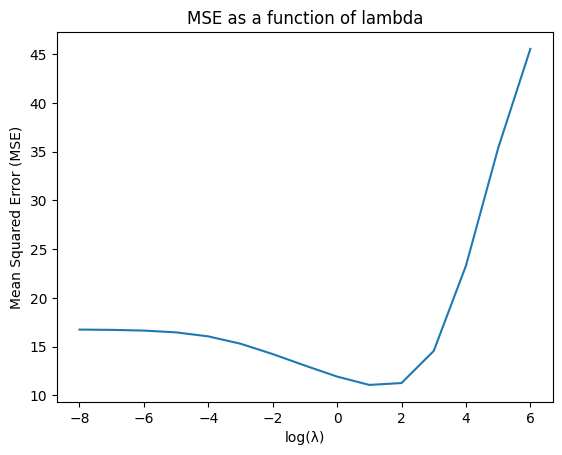

Best regularization param: 2.718281828459045


In [33]:
lambdas = np.exp(np.linspace(-8, 6, 15))

mse_scores = []

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)), 
    ('ridge', Ridge())
])

for l in lambdas:
    pipeline.set_params(ridge__alpha=l)  

    mse = -cross_val_score(pipeline, df.drop('stamina', axis=1), y, cv=10, scoring='neg_mean_squared_error').mean()
    mse_scores.append(mse)

plt.plot(np.log(lambdas), mse_scores)
plt.xlabel("log(λ)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE as a function of lambda")
plt.show()

best_lambda = lambdas[np.argmin(mse_scores)]
print("Best regularization param:", best_lambda)

### Question 7: Test error  (10 pts)
Now test how the ridge model, fitted to the whole training set, performs on the test data set. 


Report the following:

* The mean squared error on the test data - along with the 95% confidence interval, determined with the central limit theorem. 
* The proportion of the variance explained by your model - along wth a 95% confidence interval.

In [34]:
pipeline.fit(Xtrain, Ytrain)

y_pred = pipeline.predict(Xtest)

mse_test = mean_squared_error(Ytest, y_pred)

r2_test = 1 - (np.sum((Ytest - y_pred) ** 2)  / np.sum((Ytest - np.mean(Ytest)) ** 2))  

n_bootstrap = 1000
bootstrap_mse = []
bootstrap_r2 = []

np.random.seed(42)

for _ in range(n_bootstrap):
  
    indices = np.random.choice(np.arange(len(Xtest)), size=len(Xtest), replace=True)
    X_bootstrap = Xtest.iloc[indices]
    y_bootstrap = Ytest.iloc[indices]
    
  
    y_pred_bootstrap = pipeline.predict(X_bootstrap)
    

    bootstrap_mse.append(mean_squared_error(y_bootstrap, y_pred_bootstrap))
    

    ss_res_bootstrap = np.sum((y_bootstrap - y_pred_bootstrap) ** 2)
    ss_tot_bootstrap = np.sum((y_bootstrap - np.mean(y_bootstrap)) ** 2)
    bootstrap_r2.append(1 - (ss_res_bootstrap / ss_tot_bootstrap))

mse_lower, mse_upper = np.percentile(bootstrap_mse, [2.5, 97.5])
r2_lower, r2_upper = np.percentile(bootstrap_r2, [2.5, 97.5])

print("Mean Squared Error on Test Data: ",  mse_test)
print("95% Confidence Interval for MSE: ", mse_lower," to ", mse_upper)

print("R-squared on Test Data: ", r2_test)
print("95% Confidence Interval for R squared: ", r2_lower," to ", r2_upper)

Mean Squared Error on Test Data:  2.097868618012458
95% Confidence Interval for MSE:  1.779853027955255  to  2.4490147370269346
R-squared on Test Data:  0.9592959982858146
95% Confidence Interval for R squared:  0.9509345256816534  to  0.9659524689454884


## Question 8: Analyzing Ridge Coefficients (15 pts)
In this question, you are first required to extract all the coefficients of the standing tackle, composure and marking features from the best model of question 7. After that, calculate the mean of the coefficients of the aforementioned features and analyze the results. Based on these observations, draw conclusions about the results in question 4. 

In [35]:
ridge_model = pipeline.named_steps['ridge']  # Extract the Ridge model from the pipeline
feature_names = pipeline.named_steps['poly'].get_feature_names_out(Xtrain.columns)  # Get the names of all features

# Find indices for the features of interest
features_of_interest = ['standing tackle', 'composure', 'marking']
indices_of_interest = {feature: [] for feature in features_of_interest}

coefficients = ridge_model.coef_

# We need to identify the coefficients corresponding to 'standing_tackle', 'composure', and 'marking'
# Get the indices for these original features
st_index = np.where(np.array(feature_names) == 'standing_tackle')[0][0]
c_index = np.where(np.array(feature_names) == 'composure')[0][0]
mrk_index = np.where(np.array(feature_names) == 'marking')[0][0]

# Extract the coefficients for these features
st_coef = coefficients[st_index]
c_coef = coefficients[c_index]
mrk_coef = coefficients[mrk_index]

# Calculate the mean of these coefficients
mean_coef = np.mean([st_coef, c_coef, mrk_coef])

# Print the coefficients and the mean
print(f"standing tackle coef: {st_coef}")
print(f"composure coef: {c_coef}")
print(f"marking coef: {mrk_coef}")
print(f"coef means: {mean_coef}")

# Analyze the results based on the coefficients
if mean_coef > 0:
    print("The three features that were selected in q4 are positively contributing to stamina prediction")
elif mean_coef == 0:
    print("The three features that were selected in q4 are not contributing anything of significant value to stamina prediction")
else:
    print("The three features that were selected in q4 are negatively contributing to stamina prediction")

standing tackle coef: 0.5149942630508242
composure coef: 0.4537854065397476
marking coef: 0.47188457991734273
coef means: 0.48022141650263817
The three features that were selected in q4 are positively contributing to stamina prediction


## Question 9: Lasso Regression (10 pts)
Let us assume that you are building a linear regression model using only three features: standing tackle, marking, and composure to predict a player's overall rating. Based on the results of question 8, what do you think will be the features' coefficients while applying the lasso regression optimization? Answer in no more than 5 sentences. 

We may anticipate that the Lasso regression will provide distinct coefficients based on the findings from Question 8, where we examined the coefficients of the standing tackle, marking, and composure characteristics in the Ridge regression model. Due to its L1 regularization, Lasso has a tendency to produce sparse models by shrinking some coefficients precisely to zero. If the characteristics of composure, marking, and standing tackle are less important, Lasso may set some of their coefficients to zero, so eliminating them from the model. In contrast to Ridge regression, which makes use of L2 regularization, the magnitudes of the remaining features with non-zero coefficients are probably going to be less. As a result, Lasso could provide a model with fewer non-zero characteristics that is easier to understand.

## Note: 
After completing all the tasks and before submitting: 
* Restart you kernel by clicking 'Restart & Run all'
* Fix any errors resulting from the first step.
* Repeat the first two steps until no errors are encountered. 